In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

##################       IMPORT LIBRARIES AND PACKAGES      ##################

%pylab inline
import time, glob, pickle
import sklearn as skl
import scipy.optimize as so
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.metrics import make_scorer, brier_score_loss, roc_auc_score
from sklearn import metrics
# XGBoost Classification
import xgboost
from xgboost import XGBClassifier
from sklearn import model_selection

Populating the interactive namespace from numpy and matplotlib


C:\Users\aasha\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df = pd.read_excel('Supply Chain Deliveries.xlsx')

In [92]:
df.shape

(93379, 137)

In [4]:
print(df.shape, '\n\t', df.info)

(93379, 137) 
	 <bound method DataFrame.info of       Document  REV                                        DESCRIPTION  \
0        D1357    7                           ELECTRICAL BULK MATERIAL   
1         D615    0          PIPING VALVES- CARBON AND STAINLESS STEEL   
2        D2454    0                        MISCELLANEOUS PVC MATERIALS   
3        D2454    0                        MISCELLANEOUS PVC MATERIALS   
4        D1357    7                           ELECTRICAL BULK MATERIAL   
5        D2454    0                        MISCELLANEOUS PVC MATERIALS   
6         D703    0              SS SEAMLESS - PIPE, FITTINGS, FLANGES   
7         D703    0              SS SEAMLESS - PIPE, FITTINGS, FLANGES   
8         D703    0              SS SEAMLESS - PIPE, FITTINGS, FLANGES   
9         D703    0              SS SEAMLESS - PIPE, FITTINGS, FLANGES   
10        D613    3             VALVES - DESTINATION CHANGE FLD TO ITC   
11        D631    4            LTCS SEAMLESS - PIPE, FITTINGS, F

In [5]:
######################                      Including secleted columns in the final model        #######################

model_final = df[['MILESTONE_10_SCHEDULE', 'MILESTONE_10_ACTUALIZED',
                  'SUPPLIER_COUNTRY', 'DESTINATION', 'MATERIAL_TYPE', 
                  'MILESTONE_4_NAME', 'MILESTONE_4_SCHEDULE', 'MILESTONE_4_ACTUALIZED', 
                  'MILESTONE_5_NAME', 'MILESTONE_6_NAME', 'MILESTONE_8_NAME', 'MILESTONE_8_SCHEDULE', 
                  'MILESTONE_8_ACTUALIZED', 'SHIP_POINT_COUNTRY', 'SHIP_GROUP']]
print(model_final.shape)

######################                Removed entries with missing value for:                     #######################
######################   MILESTONE_10_ACTUALIZED', 'MILESTONE_10_SCHEDULE' ,'SUPPLIER_COUNTRY'    #######################

model_final = model_final.dropna(axis=0, subset=['MILESTONE_10_ACTUALIZED', 'MILESTONE_10_SCHEDULE' ,'SUPPLIER_COUNTRY' ])
print(model_final.shape)


######################      Since each shipments contianed multiple entries for products           #######################
######################               we removed duplicate values of ship_group                     #######################
######################   Will be predictng the factors that cause ontime delivery of a shipment    #######################


model_final = model_final.drop_duplicates(subset=['SHIP_GROUP'])
print(model_final.shape)

(93379, 15)
(86911, 15)
(8040, 15)


### Reducing the dataset from 93379 to 8040 rows

# Will be predicting factors that influence the delivery of shipment within 30 days of scehduled date

In [6]:
######################                      Adding 30 days to scheduled date                        #######################
###########################################################################################################################

model_final['New_Schedule_Date'] = model_final['MILESTONE_10_SCHEDULE'] + timedelta(days=30)

######################    Creating New Column indicating On-Time (within 30 days) [Binary value]     ######################
###########################################################################################################################

model_final['On Time'] = np.where(model_final['New_Schedule_Date'] < model_final['MILESTONE_10_ACTUALIZED'], 0, 1)
model_final['On Time'].value_counts()

0    4285
1    3755
Name: On Time, dtype: int64

## We have 3755 shipments that were delivered *within 30* days of scehduled date
## And 4285 shipments that were delivered *after 30* days of scehduled date

In [7]:
######################                         Reseting Index values                                 ######################
###########################################################################################################################

model_final = model_final.reset_index(drop= True)
model_final.head()

,MILESTONE_10_SCHEDULE,MILESTONE_10_ACTUALIZED,SUPPLIER_COUNTRY,DESTINATION,MATERIAL_TYPE,MILESTONE_4_NAME,MILESTONE_4_SCHEDULE,MILESTONE_4_ACTUALIZED,MILESTONE_5_NAME,MILESTONE_6_NAME,MILESTONE_8_NAME,MILESTONE_8_SCHEDULE,MILESTONE_8_ACTUALIZED,SHIP_POINT_COUNTRY,SHIP_GROUP,New_Schedule_Date,On Time
0,2012-01-06,2012-01-17,US,FLD,B,AT PACKER,2011-12-06,2011-12-06,IN TRANSIT-AIR,NaN,ARRIVED CUSTOMS,2011-12-15,2011-12-16,KR,9-6000-RR/CO 4-3,2012-02-05,1
1,2009-05-24,2009-08-24,US,PSP,B,AT PACKER,2009-04-19,2009-07-27,NaN,NaN,ARRIVED CUSTOMS,2009-05-03,2009-07-27,KR,PRO 14404 / 00184825 : 5-0001-B2-009/SRN HOU-0...,2009-06-23,0
2,2009-07-11,2009-09-13,KP,FLD,B,AT PACKER,2009-06-10,2009-07-24,IN TRANSIT-AIR,NaN,ARRIVED CUSTOMS,2009-06-19,NaT,KP,* GLORIA 29JUL09 : 9-CM5038-PL-A/SRN KOR-01/FLD,2009-08-10,0
3,2008-08-07,2009-01-08,US,SH2,B,AT PACKER,2008-06-03,2008-11-13,NaN,NaN,ARRIVED CUSTOMS,2008-07-17,2008-12-10,KP,* XIN CHANG SHU B 21NOV08 : 5-0002-E1-002/SRN ...,2008-09-06,0
4,2009-02-21,2009-09-01,US,FLD,B,AT PACKER,2009-01-21,2009-08-01,IN TRANSIT-AIR,NaN,ARRIVED CUSTOMS,2009-01-30,2009-08-10,KR,5-0001-B2-007/0007 FLD,2009-03-23,0


In [8]:
######################          Creating Categorical variables using Label Encoder          ######################
##################################################################################################################

model_final['SUPPLIER_COUNTRY'] = model_final['SUPPLIER_COUNTRY'].astype(str) 
model_final['DESTINATION'] = model_final['DESTINATION'].astype(str) 
model_final['MATERIAL_TYPE'] = model_final['MATERIAL_TYPE'].astype(str) 
model_final['SHIP_POINT_COUNTRY'] = model_final['SHIP_POINT_COUNTRY'].astype(str) 
model_final['MILESTONE_5_NAME'] = model_final['MILESTONE_5_NAME'].astype(str) 
model_final['MILESTONE_6_NAME'] = model_final['MILESTONE_6_NAME'].astype(str) 

labelencoder = LabelEncoder()

model_final['SUPPLIER_COUNTRY_Cat'] = labelencoder.fit_transform(model_final['SUPPLIER_COUNTRY'])
model_final['DESTINATION_Cat'] = labelencoder.fit_transform(model_final['DESTINATION'])
model_final['MATERIAL_TYPE_Cat'] = labelencoder.fit_transform(model_final['MATERIAL_TYPE'])
model_final['SHIP_POINT_COUNTRY_Cat'] = labelencoder.fit_transform(model_final['SHIP_POINT_COUNTRY'])
model_final['MILESTONE_5_NAME_Cat'] = labelencoder.fit_transform(model_final['MILESTONE_5_NAME'])
model_final['MILESTONE_6_NAME_Cat'] = labelencoder.fit_transform(model_final['MILESTONE_6_NAME'])
model_final.head()

,MILESTONE_10_SCHEDULE,MILESTONE_10_ACTUALIZED,SUPPLIER_COUNTRY,DESTINATION,MATERIAL_TYPE,MILESTONE_4_NAME,MILESTONE_4_SCHEDULE,MILESTONE_4_ACTUALIZED,MILESTONE_5_NAME,MILESTONE_6_NAME,...,SHIP_POINT_COUNTRY,SHIP_GROUP,New_Schedule_Date,On Time,SUPPLIER_COUNTRY_Cat,DESTINATION_Cat,MATERIAL_TYPE_Cat,SHIP_POINT_COUNTRY_Cat,MILESTONE_5_NAME_Cat,MILESTONE_6_NAME_Cat
0,2012-01-06,2012-01-17,US,FLD,B,AT PACKER,2011-12-06,2011-12-06,IN TRANSIT-AIR,nan,...,KR,9-6000-RR/CO 4-3,2012-02-05,1,11,5,0,18,0,1
1,2009-05-24,2009-08-24,US,PSP,B,AT PACKER,2009-04-19,2009-07-27,nan,nan,...,KR,PRO 14404 / 00184825 : 5-0001-B2-009/SRN HOU-0...,2009-06-23,0,11,10,0,18,1,1
2,2009-07-11,2009-09-13,KP,FLD,B,AT PACKER,2009-06-10,2009-07-24,IN TRANSIT-AIR,nan,...,KP,* GLORIA 29JUL09 : 9-CM5038-PL-A/SRN KOR-01/FLD,2009-08-10,0,6,5,0,17,0,1
3,2008-08-07,2009-01-08,US,SH2,B,AT PACKER,2008-06-03,2008-11-13,nan,nan,...,KP,* XIN CHANG SHU B 21NOV08 : 5-0002-E1-002/SRN ...,2008-09-06,0,11,11,0,17,1,1
4,2009-02-21,2009-09-01,US,FLD,B,AT PACKER,2009-01-21,2009-08-01,IN TRANSIT-AIR,nan,...,KR,5-0001-B2-007/0007 FLD,2009-03-23,0,11,5,0,18,0,1


In [10]:
######################          New Categories for on Time-Departure [@Packer]              ######################
##################################################################################################################

model_final['On_Time_Departure'] = np.where(model_final['MILESTONE_4_SCHEDULE'] < model_final['MILESTONE_4_ACTUALIZED'], 0, 1)
model_final['On_Time_Departure'] = np.where(model_final['MILESTONE_4_SCHEDULE'].isnull(), 2,
                                            model_final['On_Time_Departure'])
model_final['On_Time_Departure'] = np.where(model_final['MILESTONE_4_ACTUALIZED'].isnull(), 2,
                                            model_final['On_Time_Departure'])

######################          New Categories for on Time-Arrival [@Customs]               ######################
##################################################################################################################

model_final['On_Time_Arrival'] = np.where(model_final['MILESTONE_8_SCHEDULE'] < model_final['MILESTONE_8_ACTUALIZED'], 0, 1)

model_final['On_Time_Arrival'] = np.where(model_final['MILESTONE_8_SCHEDULE'].isnull(), 
                                            2, model_final['On_Time_Arrival'])

model_final['On_Time_Arrival'] = np.where(model_final['MILESTONE_8_ACTUALIZED'].isnull(), 
                                            2, model_final['On_Time_Arrival'])

In [11]:
print(pd.crosstab(model_final['MILESTONE_5_NAME'], model_final['MILESTONE_5_NAME_Cat'], dropna=False))
print('\n\t')
print(pd.crosstab(model_final['MILESTONE_6_NAME'], model_final['MILESTONE_6_NAME_Cat'], dropna=False))

MILESTONE_5_NAME_Cat     0     1
MILESTONE_5_NAME                
IN TRANSIT-AIR        2023     0
nan                      0  6017

	
MILESTONE_6_NAME_Cat     0     1
MILESTONE_6_NAME                
IN TRANSIT-OCEAN      2312     0
nan                      0  5728


In [12]:
print(pd.crosstab(model_final['MATERIAL_TYPE'], model_final['MATERIAL_TYPE_Cat'], dropna=False))

MATERIAL_TYPE_Cat     0    1    2    3  4    5
MATERIAL_TYPE                                 
B                  6993    0    0    0  0    0
I                     0  128    0    0  0    0
K                     0    0  137    0  0    0
M                     0    0    0  486  0    0
S                     0    0    0    0  1    0
T                     0    0    0    0  0  295


In [13]:
print(model_final['On_Time_Arrival'].value_counts())
print('\n')
print(model_final['On_Time_Departure'].value_counts())

model_final.to_excel('model_Final.xlsx', index=False)

2    5332
0    2212
1     496
Name: On_Time_Arrival, dtype: int64


0    6316
2     872
1     852
Name: On_Time_Departure, dtype: int64


In [14]:
######################          Counting Number of Categories in each column                ######################
##################################################################################################################

print('\t Number of Supplier Country: ', model_final['SUPPLIER_COUNTRY'].nunique(),'\n\t',
     'Number of Destination:      ', model_final['DESTINATION'].nunique(), '\n\t', 
     'Types of material:          ', model_final['MATERIAL_TYPE'].nunique(), '\n\t',
     'Point of shipping Country:  ', model_final['SHIP_POINT_COUNTRY'].nunique())

	 Number of Supplier Country:  12 
	 Number of Destination:       16 
	 Types of material:           6 
	 Point of shipping Country:   30


In [16]:
model_final.head()

,MILESTONE_10_SCHEDULE,MILESTONE_10_ACTUALIZED,SUPPLIER_COUNTRY,DESTINATION,MATERIAL_TYPE,MILESTONE_4_NAME,MILESTONE_4_SCHEDULE,MILESTONE_4_ACTUALIZED,MILESTONE_5_NAME,MILESTONE_6_NAME,...,New_Schedule_Date,On Time,SUPPLIER_COUNTRY_Cat,DESTINATION_Cat,MATERIAL_TYPE_Cat,SHIP_POINT_COUNTRY_Cat,MILESTONE_5_NAME_Cat,MILESTONE_6_NAME_Cat,On_Time_Departure,On_Time_Arrival
0,2012-01-06,2012-01-17,US,FLD,B,AT PACKER,2011-12-06,2011-12-06,IN TRANSIT-AIR,nan,...,2012-02-05,1,11,5,0,18,0,1,1,0
1,2009-05-24,2009-08-24,US,PSP,B,AT PACKER,2009-04-19,2009-07-27,nan,nan,...,2009-06-23,0,11,10,0,18,1,1,0,0
2,2009-07-11,2009-09-13,KP,FLD,B,AT PACKER,2009-06-10,2009-07-24,IN TRANSIT-AIR,nan,...,2009-08-10,0,6,5,0,17,0,1,0,2
3,2008-08-07,2009-01-08,US,SH2,B,AT PACKER,2008-06-03,2008-11-13,nan,nan,...,2008-09-06,0,11,11,0,17,1,1,0,0
4,2009-02-21,2009-09-01,US,FLD,B,AT PACKER,2009-01-21,2009-08-01,IN TRANSIT-AIR,nan,...,2009-03-23,0,11,5,0,18,0,1,0,0


In [17]:
######################             Response Variable                ######################
##########################################################################################

model_y = model_final['On Time']
model_y.shape

(8040,)

In [20]:
######################            Keepng Top three categories in each column                ######################
######################             Combining other categories into "OTHERS"                 ######################
##################################################################################################################


######################             SUPPLIER COUNTRY                 ######################
##########################################################################################

need = model_final['SUPPLIER_COUNTRY'].value_counts().index[:3]
model_final['SUPPLIER_COUNTRY_Cat_New'] = np.where(model_final['SUPPLIER_COUNTRY'].isin(need), model_final['SUPPLIER_COUNTRY'], 'OTHER')
valCount = model_final['SUPPLIER_COUNTRY_Cat_New'].value_counts()
print (valCount, '\n')

######################          DESTINATION COUNTRY                 ######################
##########################################################################################

need = model_final['DESTINATION'].value_counts().index[:3]
model_final['DESTINATION_Cat_New'] = np.where(model_final['DESTINATION'].isin(need), model_final['DESTINATION'], 'OTHER')
valCount = model_final['DESTINATION_Cat_New'].value_counts()
print (valCount, '\n')

######################           SHIP_POINT COUNTRY                 ######################
##########################################################################################

need = model_final['SHIP_POINT_COUNTRY'].value_counts().index[:3]
model_final['SHIP_POINT_COUNTRY_Cat_New'] = np.where(model_final['SHIP_POINT_COUNTRY'].isin(need), model_final['SHIP_POINT_COUNTRY'], 'OTHER')
valCount = model_final['SHIP_POINT_COUNTRY_Cat_New'].value_counts()
print (valCount)

US       4809
RU       2911
OTHER     216
CA        104
Name: SUPPLIER_COUNTRY_Cat_New, dtype: int64 

FLD      6625
CHY       606
MY1       462
OTHER     347
Name: DESTINATION_Cat_New, dtype: int64 

US       4120
RU       2770
OTHER     858
UK        292
Name: SHIP_POINT_COUNTRY_Cat_New, dtype: int64


In [21]:
######################           New Label Encoder                 ######################
##########################################################################################

model_final['SUPPLIER_COUNTRY_Cat_NewC'] = labelencoder.fit_transform(model_final['SUPPLIER_COUNTRY_Cat_New'])
model_final['DESTINATION_Cat_NewC'] = labelencoder.fit_transform(model_final['DESTINATION_Cat_New'])
model_final['SHIP_POINT_COUNTRY_Cat_NewC'] = labelencoder.fit_transform(model_final['SHIP_POINT_COUNTRY_Cat_New'])

In [22]:
model_final.head()

,MILESTONE_10_SCHEDULE,MILESTONE_10_ACTUALIZED,SUPPLIER_COUNTRY,DESTINATION,MATERIAL_TYPE,MILESTONE_4_NAME,MILESTONE_4_SCHEDULE,MILESTONE_4_ACTUALIZED,MILESTONE_5_NAME,MILESTONE_6_NAME,...,MILESTONE_5_NAME_Cat,MILESTONE_6_NAME_Cat,On_Time_Departure,On_Time_Arrival,SUPPLIER_COUNTRY_Cat_New,DESTINATION_Cat_New,SHIP_POINT_COUNTRY_Cat_New,SUPPLIER_COUNTRY_Cat_NewC,DESTINATION_Cat_NewC,SHIP_POINT_COUNTRY_Cat_NewC
0,2012-01-06,2012-01-17,US,FLD,B,AT PACKER,2011-12-06,2011-12-06,IN TRANSIT-AIR,nan,...,0,1,1,0,US,FLD,OTHER,3,1,0
1,2009-05-24,2009-08-24,US,PSP,B,AT PACKER,2009-04-19,2009-07-27,nan,nan,...,1,1,0,0,US,OTHER,OTHER,3,3,0
2,2009-07-11,2009-09-13,KP,FLD,B,AT PACKER,2009-06-10,2009-07-24,IN TRANSIT-AIR,nan,...,0,1,0,2,OTHER,FLD,OTHER,1,1,0
3,2008-08-07,2009-01-08,US,SH2,B,AT PACKER,2008-06-03,2008-11-13,nan,nan,...,1,1,0,0,US,OTHER,OTHER,3,3,0
4,2009-02-21,2009-09-01,US,FLD,B,AT PACKER,2009-01-21,2009-08-01,IN TRANSIT-AIR,nan,...,0,1,0,0,US,FLD,OTHER,3,1,0


In [23]:
list(model_final.columns)

['MILESTONE_10_SCHEDULE',
 'MILESTONE_10_ACTUALIZED',
 'SUPPLIER_COUNTRY',
 'DESTINATION',
 'MATERIAL_TYPE',
 'MILESTONE_4_NAME',
 'MILESTONE_4_SCHEDULE',
 'MILESTONE_4_ACTUALIZED',
 'MILESTONE_5_NAME',
 'MILESTONE_6_NAME',
 'MILESTONE_8_NAME',
 'MILESTONE_8_SCHEDULE',
 'MILESTONE_8_ACTUALIZED',
 'SHIP_POINT_COUNTRY',
 'SHIP_GROUP',
 'New_Schedule_Date',
 'On Time',
 'SUPPLIER_COUNTRY_Cat',
 'DESTINATION_Cat',
 'MATERIAL_TYPE_Cat',
 'SHIP_POINT_COUNTRY_Cat',
 'MILESTONE_5_NAME_Cat',
 'MILESTONE_6_NAME_Cat',
 'On_Time_Departure',
 'On_Time_Arrival',
 'SUPPLIER_COUNTRY_Cat_New',
 'DESTINATION_Cat_New',
 'SHIP_POINT_COUNTRY_Cat_New',
 'SUPPLIER_COUNTRY_Cat_NewC',
 'DESTINATION_Cat_NewC',
 'SHIP_POINT_COUNTRY_Cat_NewC']

In [24]:
######################             Explanatory Varaibles                 ######################
##########################################################################################

colname = ['On Time', 'SUPPLIER_COUNTRY_Cat_NewC',
 'DESTINATION_Cat_NewC',
 'SHIP_POINT_COUNTRY_Cat_NewC', 'MILESTONE_5_NAME_Cat',
 'MILESTONE_6_NAME_Cat',
 'On_Time_Departure',
 'On_Time_Arrival','MATERIAL_TYPE_Cat']

model_x = model_final.loc[:,colname]
model_x.head()

,On Time,SUPPLIER_COUNTRY_Cat_NewC,DESTINATION_Cat_NewC,SHIP_POINT_COUNTRY_Cat_NewC,MILESTONE_5_NAME_Cat,MILESTONE_6_NAME_Cat,On_Time_Departure,On_Time_Arrival,MATERIAL_TYPE_Cat
0,1,3,1,0,0,1,1,0,0
1,0,3,3,0,1,1,0,0,0
2,0,1,1,0,0,1,0,2,0
3,0,3,3,0,1,1,0,0,0
4,0,3,1,0,0,1,0,0,0


In [25]:
######################           Re-Assigning values in two column                ######################
########################################################################################################

model_x['MILESTONE_5_NAME_Cat'] = np.where(model_x['MILESTONE_5_NAME_Cat'] == 1, 2, np.where(model_x['MILESTONE_5_NAME_Cat'] == 0, 1, model_x['MILESTONE_5_NAME_Cat'] ))
model_x['MILESTONE_6_NAME_Cat'] = np.where(model_x['MILESTONE_6_NAME_Cat'] == 1, 2, np.where(model_x['MILESTONE_6_NAME_Cat'] == 0, 1, model_x['MILESTONE_6_NAME_Cat']  ))
model_x['MILESTONE_5_NAME_Cat'] = np.where(model_x['MILESTONE_5_NAME_Cat'] == 2, 0, model_x['MILESTONE_5_NAME_Cat'])
model_x['MILESTONE_6_NAME_Cat'] = np.where(model_x['MILESTONE_6_NAME_Cat'] == 2, 0, model_x['MILESTONE_6_NAME_Cat'])


pd.crosstab(model_x['MILESTONE_5_NAME_Cat'], model_x['MILESTONE_6_NAME_Cat'], dropna=False, margins=True)

MILESTONE_6_NAME_Cat,0,1,All
MILESTONE_5_NAME_Cat,,,
0,3715,2302,6017
1,2013,10,2023
All,5728,2312,8040


In [26]:
for x in model_x.columns:
    print(model_x[x].value_counts())

0    4285
1    3755
Name: On Time, dtype: int64
3    4809
2    2911
1     216
0     104
Name: SUPPLIER_COUNTRY_Cat_NewC, dtype: int64
1    6625
0     606
2     462
3     347
Name: DESTINATION_Cat_NewC, dtype: int64
3    4120
1    2770
0     858
2     292
Name: SHIP_POINT_COUNTRY_Cat_NewC, dtype: int64
0    6017
1    2023
Name: MILESTONE_5_NAME_Cat, dtype: int64
0    5728
1    2312
Name: MILESTONE_6_NAME_Cat, dtype: int64
0    6316
2     872
1     852
Name: On_Time_Departure, dtype: int64
2    5332
0    2212
1     496
Name: On_Time_Arrival, dtype: int64
0    6993
3     486
5     295
2     137
1     128
4       1
Name: MATERIAL_TYPE_Cat, dtype: int64


In [27]:
model_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 9 columns):
On Time                        8040 non-null int32
SUPPLIER_COUNTRY_Cat_NewC      8040 non-null int32
DESTINATION_Cat_NewC           8040 non-null int32
SHIP_POINT_COUNTRY_Cat_NewC    8040 non-null int32
MILESTONE_5_NAME_Cat           8040 non-null int32
MILESTONE_6_NAME_Cat           8040 non-null int32
On_Time_Departure              8040 non-null int32
On_Time_Arrival                8040 non-null int32
MATERIAL_TYPE_Cat              8040 non-null int32
dtypes: int32(9)
memory usage: 282.7 KB


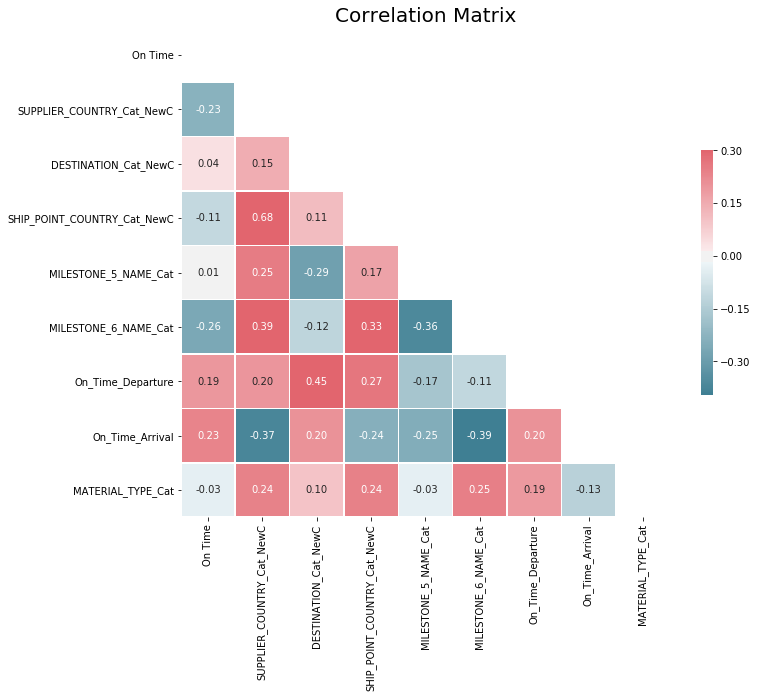

In [28]:
######################          Finding Correlation with Outcome Variable               ######################
##############################################################################################################


corr_matrix=model_x.corr(method='spearman')
corr_matrix.style.background_gradient()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# fig=plt.figure(figsize=(12,12))
# Draw the heatmap with the mask and correct aspect ratio
fig1 = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
ax.set_title('Correlation Matrix', fontsize = 20)
# swarm_plot = sns.swarmplot(...)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
fig = fig1.get_figure()
fig.savefig("Corr_all.png", bbox_inches = 'tight')
plt.show() # ta-da!

In [29]:
print(model_final['SHIP_POINT_COUNTRY_Cat_New'].value_counts(), '\n\t',
         model_final['SUPPLIER_COUNTRY_Cat_New'].value_counts(),'\n\t',
         model_final['DESTINATION_Cat_New'].value_counts(),'\n\t')

print('\n')

print(model_x['SHIP_POINT_COUNTRY_Cat_NewC'].value_counts(), '\n\t',
         model_x['SUPPLIER_COUNTRY_Cat_NewC'].value_counts(),'\n\t',
         model_x['DESTINATION_Cat_NewC'].value_counts(),'\n\t')

US       4120
RU       2770
OTHER     858
UK        292
Name: SHIP_POINT_COUNTRY_Cat_New, dtype: int64 
	 US       4809
RU       2911
OTHER     216
CA        104
Name: SUPPLIER_COUNTRY_Cat_New, dtype: int64 
	 FLD      6625
CHY       606
MY1       462
OTHER     347
Name: DESTINATION_Cat_New, dtype: int64 
	


3    4120
1    2770
0     858
2     292
Name: SHIP_POINT_COUNTRY_Cat_NewC, dtype: int64 
	 3    4809
2    2911
1     216
0     104
Name: SUPPLIER_COUNTRY_Cat_NewC, dtype: int64 
	 1    6625
0     606
2     462
3     347
Name: DESTINATION_Cat_NewC, dtype: int64 
	


#########################                 SHIP-POINT Categorization                #####################################
#0 = Other
#1 = RU
#2 = UK
#3 = US

#########################              SUPPLIER COUNTRY Categorization             #####################################
#0 = CA
#1 = Other
#2 = RU
#3 = US
#########################                    DESTINATION Country                   #####################################

#0 = CHY
#1 = FLD
#2 = MY1
#3 = OTHER


In [30]:
model_y.value_counts()

0    4285
1    3755
Name: On Time, dtype: int64

In [31]:
model_x = model_x.iloc[:,1:]
model_x.head()

,SUPPLIER_COUNTRY_Cat_NewC,DESTINATION_Cat_NewC,SHIP_POINT_COUNTRY_Cat_NewC,MILESTONE_5_NAME_Cat,MILESTONE_6_NAME_Cat,On_Time_Departure,On_Time_Arrival,MATERIAL_TYPE_Cat
0,3,1,0,1,0,1,0,0
1,3,3,0,0,0,0,0,0
2,1,1,0,1,0,0,2,0
3,3,3,0,0,0,0,0,0
4,3,1,0,1,0,0,0,0


### LOGISTIC REGRESSION

In [34]:
###############################            Getting Dummies for Categorical Data           ###############################
#########################################################################################################################

Categorical_Columns = list(model_x)
Categorical_Predictors_Binary = pd.get_dummies( model_x , columns = Categorical_Columns )

###############################            Removing Redundant Information           ###############################
###################################################################################################################

X = Categorical_Predictors_Binary.loc[:, ~Categorical_Predictors_Binary.columns.str.endswith('_0')]
list(X.columns)


['SUPPLIER_COUNTRY_Cat_NewC_1',
 'SUPPLIER_COUNTRY_Cat_NewC_2',
 'SUPPLIER_COUNTRY_Cat_NewC_3',
 'DESTINATION_Cat_NewC_1',
 'DESTINATION_Cat_NewC_2',
 'DESTINATION_Cat_NewC_3',
 'SHIP_POINT_COUNTRY_Cat_NewC_1',
 'SHIP_POINT_COUNTRY_Cat_NewC_2',
 'SHIP_POINT_COUNTRY_Cat_NewC_3',
 'MILESTONE_5_NAME_Cat_1',
 'MILESTONE_6_NAME_Cat_1',
 'On_Time_Departure_1',
 'On_Time_Departure_2',
 'On_Time_Arrival_1',
 'On_Time_Arrival_2',
 'MATERIAL_TYPE_Cat_1',
 'MATERIAL_TYPE_Cat_2',
 'MATERIAL_TYPE_Cat_3',
 'MATERIAL_TYPE_Cat_4',
 'MATERIAL_TYPE_Cat_5']

In [38]:
Y = model_y

print(X.shape, Y.shape)

(8040, 20) (8040,)


In [39]:
#################          TRAINING & TEST DATASETS          #################
##############################################################################

#################          Create stratified training and test splits          #################
################################################################################################
N_Folds_Cross_Validation       = 10 
Random_Number_Generation_Seed  = 1234

Xo_train, Xo_test, y_train, y_test = train_test_split( X , Y , test_size=0.2, random_state= Random_Number_Generation_Seed
                                                      , stratify=Y )
cv = StratifiedKFold(n_splits= N_Folds_Cross_Validation )

In [40]:
print(type(                     X.values                                      ),
type(                     Y.values                                      ))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [41]:
##############################################################################
##########      K-Fold Cross Validation: Logistic Regression       ###########  

olasso = LogisticRegressionCV(Cs=100, cv=cv, penalty='l1', solver='liblinear', scoring='roc_auc')
%time olasso.fit(Xo_train, y_train)

olr = LogisticRegression(penalty='l1', C = olasso.C_[0])
olr.fit(Xo_train, y_train)

Wall time: 47.6 s


LogisticRegressionCV(Cs=100, class_weight=None,
           cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring='roc_auc',
           solver='liblinear', tol=0.0001, verbose=0)

In [42]:
print("Best score:", olasso.scores_[1].mean(axis=0).max())

Best score: 0.8173618113270837


In [45]:
olr = LogisticRegression(penalty='l1', C = olasso.C_[0])
olr.fit(Xo_train, y_train)

C:\Users\aasha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=890.2150854450392, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [46]:
# Calculate matrix of predicted class probabilities.
# Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
predProbs = olr.predict_proba(Xo_train)

# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.hstack([np.ones((Xo_train.shape[0], 1)), Xo_train])

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.diagflat(np.product(predProbs, axis=1))

# Covariance matrix
# Note that the @-operater does matrix multiplication in Python 3.5+, so if you're running
# Python 3.5+, you can replace the covLogit-line below with the more readable:
# covLogit = np.linalg.inv(X_design.T @ V @ X_design)
covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
# print("Covariance matrix: ", covLogit)

# Standard errors
# print("Standard errors: ", np.sqrt(np.diag(covLogit)))

# Wald statistic (coefficient / s.e.) ^ 2
logitParams = np.insert(olr.coef_, 0, olr.intercept_)
print("Wald statistics: ", (logitParams / np.sqrt(np.diag(covLogit))) ** 2)

Wald statistics:  [3.98579362e+01 1.12509748e+01 2.09360856e+00 1.14777714e+00
 1.49590540e+02 3.94114845e-01 8.57085471e+00 9.32082218e-02
 2.81489897e+00 1.06202690e+01 4.90183681e+00 1.21465844e+02
 1.90670542e+02 1.73668207e+01 1.35536164e+02 2.43403134e+01
 2.17922288e+01 8.29061613e-01 4.56831334e+01 2.67646640e-02
 6.19498266e+01]


In [47]:
Categorical_Columns = list(X)

# Summarize predictor coefficients
k = 1
cs_olr = pd.DataFrame()
cs_olr['Coef'] = logitParams
cs_olr['SE'] = np.sqrt(np.diag(covLogit)).tolist()
# cs_olr.loc['Intercept'] = olr.intercept_
cs_olr['Odds Ratio'] = np.exp(cs_olr['Coef'])
cs_olr['95% UI'] = np.exp(cs_olr['Coef']+1.96*cs_olr['SE'])
cs_olr['95% LI'] = np.exp(cs_olr['Coef']-1.96*cs_olr['SE'])
cs_olr.rename(index={0:'Intercept'},inplace=True)
cs_olr = cs_olr.round(4)
cs_olr.to_csv('coefs_olr' + str(k) + '_new.csv', index=True)
# cs_olr['StandardError'] = np.sqrt(np.diag(covLogit)).tolist()
cs_olr

,Coef,SE,Odds Ratio,95% UI,95% LI
Intercept,-2.4249,0.3841,0.0885,1.879000e-01,0.0417
1,1.2675,0.3779,3.5521,7.450000e+00,1.6936
2,0.5578,0.3855,1.7468,3.718400e+00,0.8206
3,0.3458,0.3228,1.4131,2.660400e+00,0.7506
4,1.9100,0.1562,6.7528,9.170900e+00,4.9723
5,-0.1575,0.2509,0.8543,1.396900e+00,0.5224
6,-0.7683,0.2624,0.4638,7.758000e-01,0.2773
7,0.0828,0.2712,1.0863,1.848400e+00,0.6384
8,-0.3713,0.2213,0.6898,1.064500e+00,0.4471
9,0.4629,0.1420,1.5887,2.098700e+00,1.2026


In [48]:
# Summarize predictor coefficients
k = 1
cs_olr1 = pd.DataFrame({'Coefficients': olr.coef_[0]}, index=Categorical_Columns)
cs_olr1.loc['Intercept'] = olr.intercept_
cs_olr1['Odds Ratio'] = np.exp(cs_olr1['Coefficients'])
cs_olr1.to_csv('coefs_olr' + str(k) + '_old.csv', index=True)
cs_olr1

,Coefficients,Odds Ratio
SUPPLIER_COUNTRY_Cat_NewC_1,1.267544,3.552119
SUPPLIER_COUNTRY_Cat_NewC_2,0.557762,1.746760
SUPPLIER_COUNTRY_Cat_NewC_3,0.345818,1.413145
DESTINATION_Cat_NewC_1,1.909956,6.752789
DESTINATION_Cat_NewC_2,-0.157509,0.854269
DESTINATION_Cat_NewC_3,-0.768270,0.463815
SHIP_POINT_COUNTRY_Cat_NewC_1,0.082791,1.086315
SHIP_POINT_COUNTRY_Cat_NewC_2,-0.371295,0.689841
SHIP_POINT_COUNTRY_Cat_NewC_3,0.462922,1.588710
MILESTONE_5_NAME_Cat_1,-0.413081,0.661609


In [49]:
######################  Using the model to predict Testing set  ########################

y_predict_lr = olr.predict(Xo_test)

y_predict_prob_lr = olr.predict_proba(Xo_test)
print("Prediction of Test Variable:",y_predict_lr)
y_predict_prob_df_lr = pd.DataFrame(y_predict_prob_lr)
y_predict_prob_df_lr.columns = ['Delay', 'On-Time']
y_predict_prob_df_lr.head()

Prediction of Test Variable: [1 0 1 ... 1 0 0]


,Delay,On-Time
0,0.195778,0.804222
1,0.529793,0.470207
2,0.370656,0.629344
3,0.418271,0.581729
4,0.418271,0.581729


Text(0.5, 0, 'Probabilities')

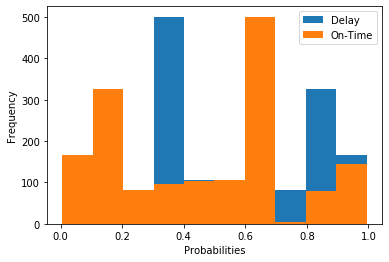

In [50]:
y_predict_prob_df_lr.plot(kind='hist');
xlabel('Probabilities')

In [51]:
print(metrics.accuracy_score(y_test, y_predict_lr, normalize=True))
print(metrics.precision_score(y_test, y_predict_lr, average= 'micro'))
print(metrics.recall_score(y_test, y_predict_lr, average= 'micro'))
print(metrics.classification_report(y_test, y_predict_lr))
print(metrics.confusion_matrix(y_test, y_predict_lr))

0.753731343283582
0.753731343283582
0.753731343283582
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       857
           1       0.71      0.79      0.75       751

   micro avg       0.75      0.75      0.75      1608
   macro avg       0.76      0.76      0.75      1608
weighted avg       0.76      0.75      0.75      1608

[[617 240]
 [156 595]]


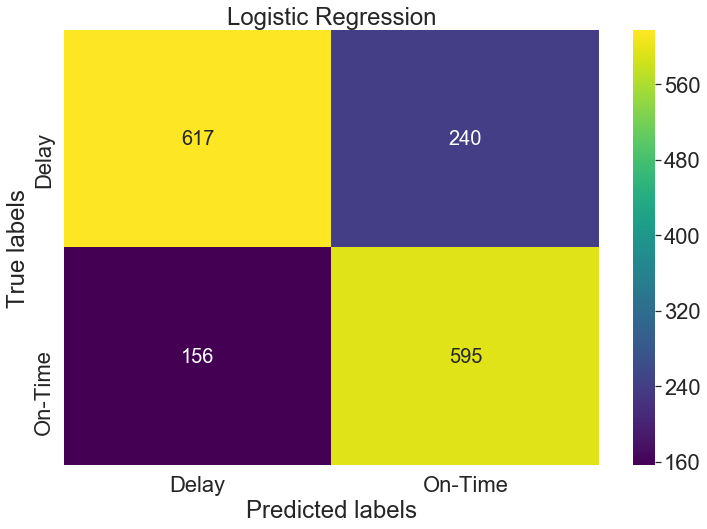

In [52]:
df_cfm_lr=pd.DataFrame(data=y_predict_lr,columns=["Prediction"])
df_cfm_lr["Actual"]=pd.DataFrame(data=y_test.values)

confusion_matrix_lr=pd.crosstab(df_cfm_lr["Actual"],df_cfm_lr["Prediction"])
plt.figure(figsize=(12,8))
sns.set(font_scale=2) 
ax = plt.axes()
sns.heatmap(confusion_matrix_lr,annot=True,cmap="viridis",annot_kws={"size": 20}, ax = ax,  fmt='g')
ax.set_title('Logistic Regression')
ax.set_ylim(2.0, 0) 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Delay', 'On-Time']); ax.yaxis.set_ticklabels(['Delay','On-Time']);
plt.savefig('LR.png')

## Decision Tree

In [53]:
###############################################################################
###################        DECISION TREE CLASSIFIER        ####################

param_grid={'min_samples_split': range(2, 403, 10),
           'max_depth': range(1,50)}

tree_clf = DecisionTreeClassifier(random_state=Random_Number_Generation_Seed )

tree_clf_CV = GridSearchCV( estimator= tree_clf, param_grid=param_grid, cv = cv, scoring='roc_auc', n_jobs=4)

%time tree_clf_CV.fit(Xo_train, y_train)

tree_clf = DecisionTreeClassifier(random_state=1234, max_depth=12, min_samples_split=52)
tree_clf.fit(Xo_train, y_train)

Wall time: 1min 17s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_samples_split': range(2, 403, 10), 'max_depth': range(1, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [54]:
print(tree_clf_CV.best_params_, tree_clf_CV.best_score_)

{'max_depth': 12, 'min_samples_split': 52} 0.8234047413948524


In [55]:
# Feature importance
k=1
odt = tree_clf_CV.best_estimator_
ofidf = pd.DataFrame({'Importance': odt.feature_importances_}, index=Categorical_Columns)
ofidf.to_csv('odt_featimpo' + str(k) + '.csv', index=True)
ofidf.sort_values(by='Importance', ascending=False)

,Importance
MILESTONE_6_NAME_Cat_1,0.276996
On_Time_Departure_1,0.232637
DESTINATION_Cat_NewC_1,0.177777
On_Time_Arrival_1,0.098793
MATERIAL_TYPE_Cat_3,0.046727
MILESTONE_5_NAME_Cat_1,0.038856
MATERIAL_TYPE_Cat_5,0.024954
On_Time_Departure_2,0.020111
SHIP_POINT_COUNTRY_Cat_NewC_1,0.017135
MATERIAL_TYPE_Cat_1,0.012432


In [56]:
tree_clf = DecisionTreeClassifier(random_state=1234, max_depth=12, min_samples_split=52)
tree_clf.fit(Xo_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=52,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

In [57]:
target_names = ['Delay', 'On-Time']

In [58]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = ""
CHAPTER_ID = ""

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [59]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=image_path("shipment_tree.dot"),
        feature_names=list(X.columns),
        class_names=target_names,
        rounded=True,
        filled=True
    )

In [60]:
######################  Using the model to predict Testing set  ########################

y_predict_dt = tree_clf.predict(Xo_test)

y_predict_prob_dt = tree_clf.predict_proba(Xo_test)
print("Prediction of Test Variable:",y_predict_dt)
y_predict_prob_df_dt = pd.DataFrame(y_predict_prob_dt)
y_predict_prob_df_dt.columns = target_names
y_predict_prob_df_dt.head()

Prediction of Test Variable: [1 0 1 ... 1 0 0]


,Delay,On-Time
0,0.384615,0.615385
1,0.510256,0.489744
2,0.064516,0.935484
3,0.476071,0.523929
4,0.476071,0.523929


Text(0.5, 0, 'Probabilities')

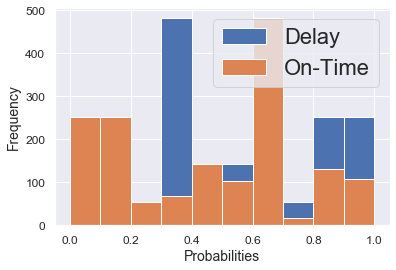

In [62]:
y_predict_prob_df_dt.plot(kind='hist');
xlabel('Probabilities')

In [63]:
print(metrics.accuracy_score(y_test, y_predict_dt, normalize=True))
print(metrics.precision_score(y_test, y_predict_dt, average= 'micro'))
print(metrics.recall_score(y_test, y_predict_dt, average= 'micro'))
# print(metrics.roc_auc_score(y_test, y_predict, average='micro'))
print(metrics.classification_report(y_test, y_predict_dt))
print(metrics.confusion_matrix(y_test, y_predict_dt))

0.7524875621890548
0.7524875621890548
0.7524875621890548
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       857
           1       0.71      0.79      0.75       751

   micro avg       0.75      0.75      0.75      1608
   macro avg       0.75      0.76      0.75      1608
weighted avg       0.76      0.75      0.75      1608

[[614 243]
 [155 596]]


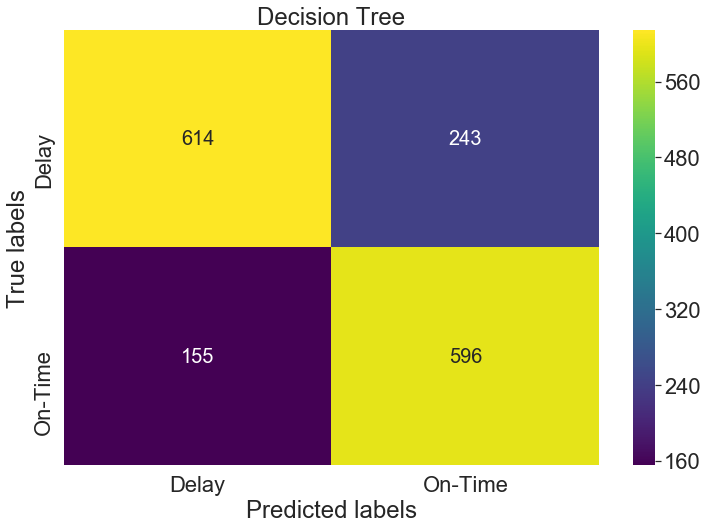

In [64]:
df_cfm_dt=pd.DataFrame(data=y_predict_dt,columns=["Prediction"])
df_cfm_dt["Actual"]=pd.DataFrame(data=y_test.values)

confusion_matrix_dt=pd.crosstab(df_cfm_dt["Actual"],df_cfm_dt["Prediction"])
plt.figure(figsize=(12,8))
sns.set(font_scale=2) 
ax = plt.axes()
sns.heatmap(confusion_matrix_dt,annot=True,cmap="viridis",annot_kws={"size": 20}, ax = ax,  fmt='g')
ax.set_title('Decision Tree')
ax.set_ylim(2.0, 0) 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Delay', 'On-Time']); ax.yaxis.set_ticklabels(['Delay','On-Time']);
plt.savefig('dt.png')

## Random Forest

In [109]:
param_grid = { 'n_estimators': [200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
# training Random Forest 

rfc = RandomForestClassifier(random_state= 1234)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= cv, scoring='accuracy', n_jobs=4)
%time CV_rfc.fit(Xo_train, y_train)

print(CV_rfc.best_params_, CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200} 0.7411380597014925


In [125]:
rfc1 = CV_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [69]:
rfc1.fit(Xo_train, y_train);
y_predict_rfc = rfc1.predict(Xo_test)

In [70]:
# Feature importance
k=1
orf = CV_rfc.best_estimator_
ofidf = pd.DataFrame({'Importance': orf.feature_importances_}, index=Categorical_Columns)
ofidf.to_csv('orf_featimpo' + str(k) + '.csv', index=True)
ofidf.sort_values(by='Importance', ascending=False)

,Importance
On_Time_Departure_1,0.191059
MILESTONE_6_NAME_Cat_1,0.141681
On_Time_Arrival_1,0.139958
DESTINATION_Cat_NewC_1,0.096830
SHIP_POINT_COUNTRY_Cat_NewC_1,0.075270
MATERIAL_TYPE_Cat_3,0.060715
On_Time_Arrival_2,0.046756
SUPPLIER_COUNTRY_Cat_NewC_2,0.045473
SUPPLIER_COUNTRY_Cat_NewC_3,0.042941
MILESTONE_5_NAME_Cat_1,0.042864


In [71]:
y_predict_prob_rfc = rfc1.predict_proba(Xo_test)

print("Prediction of Test Variable:",y_predict_rfc)

y_predict_prob_df_rfc = pd.DataFrame(y_predict_prob_rfc)

y_predict_prob_df_rfc.columns = target_names

y_predict_prob_df_rfc.head()

Prediction of Test Variable: [1 0 1 ... 1 0 0]


,Delay,On-Time
0,0.350670,0.649330
1,0.544553,0.455447
2,0.260479,0.739521
3,0.513817,0.486183
4,0.513817,0.486183


Text(0.5, 0, 'Probabilities')

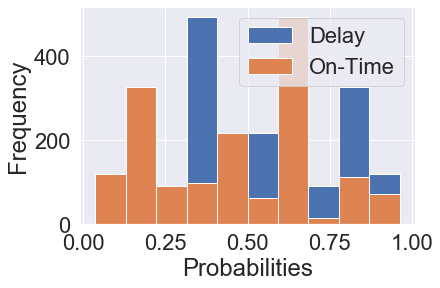

In [72]:
y_predict_prob_df_rfc.plot(kind='hist');
xlabel('Probabilities')

In [73]:
print(metrics.accuracy_score(y_test, y_predict_rfc, normalize=True ))
print(metrics.precision_score(y_test, y_predict_rfc, average= 'micro'))
print(metrics.recall_score(y_test, y_predict_rfc, average= 'micro'))
# print(metrics.roc_auc_score(y_test, y_predict, average='micro'))
print(metrics.classification_report(y_test, y_predict_rfc))
print(metrics.confusion_matrix(y_test, y_predict_rfc))

0.7618159203980099
0.7618159203980099
0.7618159203980099
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       857
           1       0.74      0.75      0.75       751

   micro avg       0.76      0.76      0.76      1608
   macro avg       0.76      0.76      0.76      1608
weighted avg       0.76      0.76      0.76      1608

[[664 193]
 [190 561]]


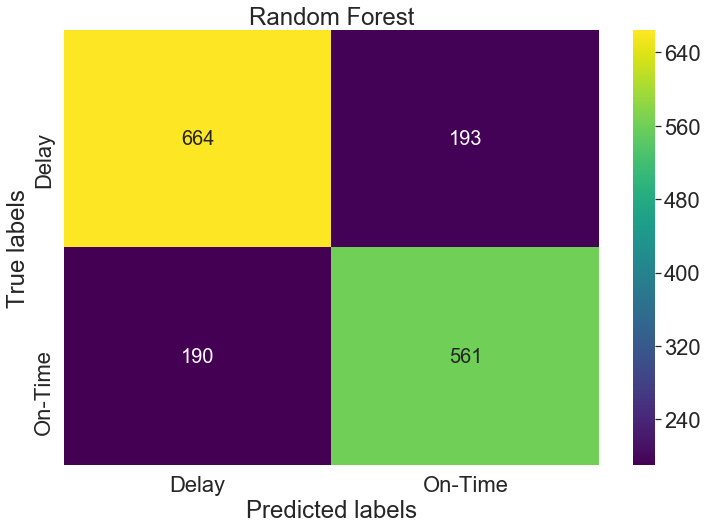

In [74]:
df_cfm_rfc=pd.DataFrame(data=y_predict_rfc,columns=["Prediction"])
df_cfm_rfc["Actual"]=pd.DataFrame(data=y_test.values)

confusion_matrix_rfc=pd.crosstab(df_cfm_rfc["Actual"],df_cfm_rfc["Prediction"])
plt.figure(figsize=(12,8))
sns.set(font_scale=2) 
ax = plt.axes()
sns.heatmap(confusion_matrix_rfc,annot=True,cmap="viridis",annot_kws={"size": 20}, ax = ax,  fmt='g')
ax.set_title('Random Forest')
ax.set_ylim(2.0, 0) 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Delay', 'On-Time']); ax.yaxis.set_ticklabels(['Delay','On-Time']);
plt.savefig('rfc.png')

## Support Vector Method

In [75]:
from sklearn.svm import LinearSVC, SVC

In [110]:
param_grid = {'C' : linspace(0.5,2,15),'kernel' : ['linear'],'degree' : range(1,5), 'coef0' : range(1,3),}

svc = SVC(probability=True)
SVC_grid = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv , scoring='accuracy', n_jobs=4  )
%time SVC_grid.fit(Xo_train, y_train)

print(SVC_grid.best_params_, SVC_grid.best_score_)

{'C': 0.6071428571428571, 'coef0': 1, 'degree': 1, 'kernel': 'linear'} 0.7356965174129353


In [78]:
# Assign the tuned model
SVC_B = SVC_grid.best_estimator_
SVC_B

SVC(C=0.6071428571428571, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [79]:
y_pred_svc = SVC_B.predict(Xo_test)
y_pred_svc_prob = SVC_B.predict_proba(Xo_test)


print("Prediction of Test Variable:",y_pred_svc)

y_predict_prob_df_svc = pd.DataFrame(y_pred_svc_prob)

y_predict_prob_df_svc.head()

Prediction of Test Variable: [1 1 0 ... 1 0 0]


,0,1
0,0.342939,0.657061
1,0.343267,0.656733
2,0.785972,0.214028
3,0.343117,0.656883
4,0.343117,0.656883


In [80]:
print(metrics.accuracy_score(y_test, y_pred_svc, normalize=True ))
print(metrics.precision_score(y_test, y_pred_svc, average= 'micro'))
print(metrics.recall_score(y_test, y_pred_svc, average= 'micro'))
# print(metrics.roc_auc_score(y_test, y_predict, average='micro'))
print(metrics.classification_report(y_test, y_pred_svc))
print(metrics.confusion_matrix(y_test, y_pred_svc))

0.7475124378109452
0.7475124378109452
0.7475124378109452
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       857
           1       0.68      0.86      0.76       751

   micro avg       0.75      0.75      0.75      1608
   macro avg       0.76      0.75      0.75      1608
weighted avg       0.77      0.75      0.75      1608

[[559 298]
 [108 643]]


In [82]:
SVC_grid.best_estimator_

SVC(C=0.6071428571428571, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

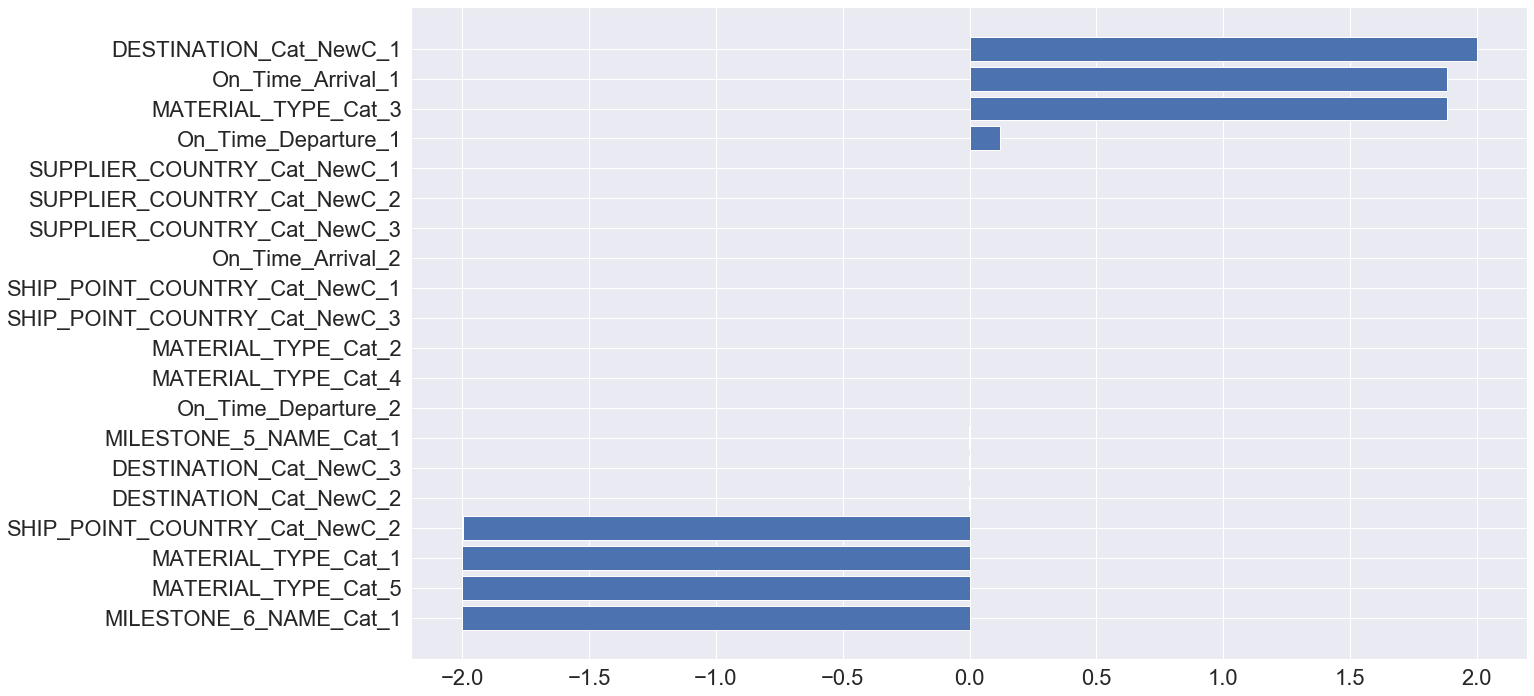

In [83]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(20,12))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = list(X.columns)
f_importances(SVC_B.coef_[0], list(X.columns))


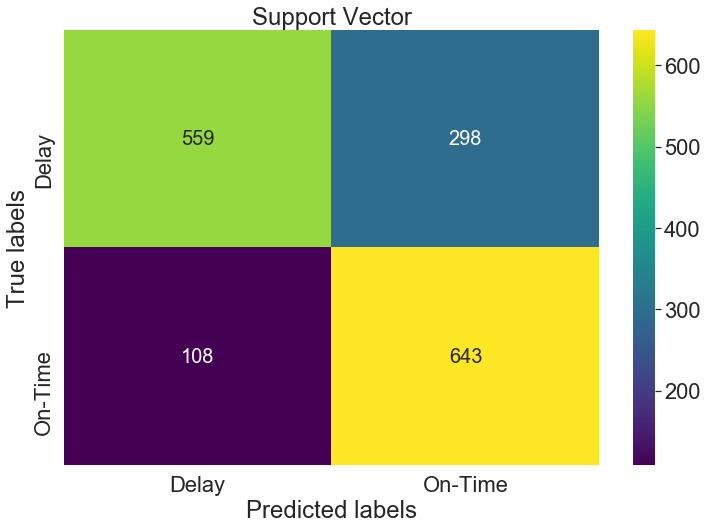

In [84]:
df_cfm_svc=pd.DataFrame(data=y_pred_svc,columns=["Prediction"])
df_cfm_svc["Actual"]=pd.DataFrame(data=y_test.values)

confusion_matrix_svc=pd.crosstab(df_cfm_svc["Actual"],df_cfm_svc["Prediction"])
plt.figure(figsize=(12,8))
sns.set(font_scale=2) 
ax = plt.axes()
sns.heatmap(confusion_matrix_svc,annot=True,cmap="viridis",annot_kws={"size": 20}, ax = ax,  fmt='g')
ax.set_title('Support Vector')
ax.set_ylim(2.0, 0) 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Delay', 'On-Time']); ax.yaxis.set_ticklabels(['Delay','On-Time']);
plt.savefig('svc.png')

## Senstivity analysis

C:\Users\aasha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aasha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aasha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aasha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aasha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

LR: 0.744555 (0.014754)
DT: 0.741602 (0.014549)
RF: 0.741138 (0.014197)
SVM: 0.735686 (0.019029)


C:\Users\aasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


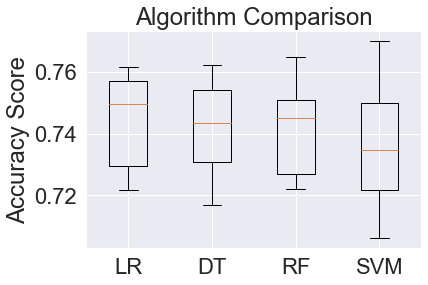

In [91]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(penalty='l1', C = olasso.C_[0])))
models.append(('DT', DecisionTreeClassifier(random_state=1234, max_depth=12, min_samples_split=52)))
models.append(('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)))
models.append(('SVM', SVC(C=0.6071428571428571, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv = StratifiedKFold(n_splits= N_Folds_Cross_Validation )
    cv_results = model_selection.cross_val_score(model, Xo_train, y_train, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
plt.title('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy Score')
plt.savefig("Accuracy_Score.png")
plt.show()

In [128]:
models=["Random Forest"]
rf_accuracy=[]
split_ratio=[]

for i in range(1,99):
    ##Defining split size
    a=0.01*i
    split_ratio.append(a)
    
    #Splitting the data
    Xo_train, Xo_test, y_train, y_test = train_test_split( X , Y , test_size=a, random_state= 1234  , stratify=Y )
    
     #making the RF model
    rfc_sv = RandomForestClassifier(n_estimators=200,max_depth=7,random_state= 1234,min_samples_leaf=2, criterion="entropy");
    rfc_sv.fit(Xo_train, y_train);
    #Predicting the test value
    y_predict_rfc = rfc_sv.predict(Xo_test)
    rf_accuracy.append(metrics.accuracy_score(y_test, y_predict_rfc, normalize=True ))

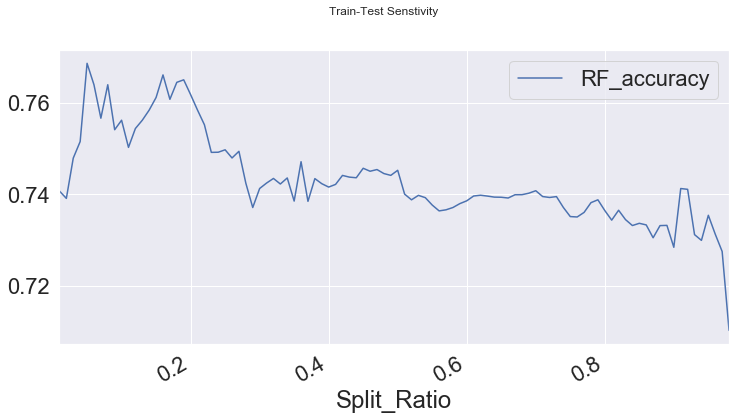

In [129]:
df_results=pd.DataFrame()
df_results['Split_Ratio']=split_ratio
df_results['RF_accuracy']=rf_accuracy

df_results.plot(x="Split_Ratio",y=['RF_accuracy'],figsize = (12,6),
                sharex=True,title = 'Train-Test Senstivity',subplots=True);
plt.savefig('ses.png')

In [130]:
df_results[df_results["RF_accuracy"]==df_results.RF_accuracy.max()]

,Split_Ratio,RF_accuracy
4,0.05,0.768657
